# Import necessary libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


# Loading train and test data

In [2]:
ddf = pd.read_csv('data/train.csv')
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
test_df = pd.read_csv('data/test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

**сразу заметим, что тестовый датасет был дан для соревнований - в нем нет разметки, поэтому нам он не пригодится совсем!**

# Адресуем проклятие размерности

Заметим, что датасет весьма короткий - едва полторы тысячи объектов - строить регрессию на 80 предикторах было бы сложно, даже при всех числовых полях, а категориальные (их 1/3) могут раздуть при one-hot-encoding размерность в разы, сделав задачу линейной системы банально недоопределенной!

Поэтому начать следовало бы с интенсивного EDA и выделения важных признаков, но на это ушло бы 90% времени, поэтому сперва немного читинга: определим сразу самые важные поля и критические категории для нечисловых из них (при этом заодно заменим ohe категориальных на бинарный выбор критического значения для них!) 

Поэтому мы сперва крутанули CatBoost или XGBoost и получили 30 вариантов variable importance на кросс-валидационных разбиениях train.csv - приаттачено в ДЗ как **var_imp.zip** и используется кодом ниже:

# Select top important predictors

In [4]:
var_imp_dir = 'var_imp'

var_imp_files = [f for f in os.listdir(var_imp_dir)]

all_df = pd.DataFrame()
for fl in var_imp_files:
    df = pd.read_csv('/'.join([var_imp_dir, fl]), sep=';').iloc[:,[0,-1]]
    all_df = pd.concat([all_df,df], axis=0, ignore_index=True)
avg_all_df = all_df.groupby('variable').percentage.mean().sort_values(ascending=False).reset_index()
avg_all_df['crit_val'] = avg_all_df.variable.map(lambda s: s.split('.')[1] if len(s.split('.'))>1 else 'no_crit_val')
avg_all_df.variable = avg_all_df.variable.map(lambda s: s.split('.')[0])
avg_all_df['cumul_perc'] = avg_all_df.percentage.cumsum()

In [5]:
avg_all_df = avg_all_df.merge(ddf.dtypes.reset_index().rename(columns={'index':'variable',0:'dtype'}), how='left', on='variable')
avg_all_df['fld_type'] = avg_all_df['dtype'].map(lambda s: 'cat' if s=='object' else 'num')

In [6]:
avg_all_df.head(30)

,variable,percentage,crit_val,cumul_perc,dtype,fld_type
0,OverallQual,0.639066,no_crit_val,0.639066,int64,num
1,GrLivArea,0.112639,no_crit_val,0.751705,int64,num
2,GarageCars,0.043064,no_crit_val,0.794768,int64,num
3,TotalBsmtSF,0.036681,no_crit_val,0.831449,int64,num
4,BsmtFinSF1,0.025894,no_crit_val,0.857343,int64,num
5,1stFlrSF,0.015113,no_crit_val,0.872456,int64,num
6,BsmtQual,0.012942,Ex,0.885398,object,cat
7,2ndFlrSF,0.012719,no_crit_val,0.898117,int64,num
8,LotArea,0.009484,no_crit_val,0.907601,int64,num
9,YearBuilt,0.007202,no_crit_val,0.914804,int64,num


Из собранной таблицы важности предикторов видно, что на 28-ом по важности мы додетализировались "уже до ежиков" - просто ID!  Так что ограничимся первыми 27, охватывая порядка 97% кумулятивной важности 

In [7]:
top_predictors_list = list(avg_all_df.variable)[:27]

crit_val_dict = dict(zip(avg_all_df.iloc[:27].variable, avg_all_df.iloc[:27].crit_val))
cat_predictors_dict = {}
for fld in avg_all_df.iloc[:27].query('fld_type == "cat"').variable:
    if fld != 'FireplaceQu':
        cat_predictors_dict[fld] = crit_val_dict[fld]


cat_predictors_dict

{'BsmtQual': 'Ex',
 'Neighborhood': 'Edwards',
 'KitchenQual': 'Ex',
 'CentralAir': 'N',
 'LandContour': 'Bnk',
 'MSZoning': 'RM',
 'PoolQC': 'Ex'}

# Preprocessing categories to numeric

**NB!:** итак, категориальные мы не разбиваем на все варианты с помощью ohe, но пользуемся полученным выше variable importance с найденными критичными категориями - просто кодируем по ним как бинарные поля!

In [8]:
for fld in cat_predictors_dict.keys():
    ddf[fld] = ddf[fld].map(lambda s: int(s == cat_predictors_dict[fld]))

ddf['FireplaceQu'] = ddf['FireplaceQu'].notna().map(int)  # для этого поля variable importance показала, что важна его пустотность

In [9]:
ddf = ddf[top_predictors_list + ['SalePrice']].copy('deep')

In [10]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   GrLivArea     1460 non-null   int64  
 2   GarageCars    1460 non-null   int64  
 3   TotalBsmtSF   1460 non-null   int64  
 4   BsmtFinSF1    1460 non-null   int64  
 5   1stFlrSF      1460 non-null   int64  
 6   BsmtQual      1460 non-null   int64  
 7   2ndFlrSF      1460 non-null   int64  
 8   LotArea       1460 non-null   int64  
 9   YearBuilt     1460 non-null   int64  
 10  GarageArea    1460 non-null   int64  
 11  YearRemodAdd  1460 non-null   int64  
 12  FullBath      1460 non-null   int64  
 13  Neighborhood  1460 non-null   int64  
 14  TotRmsAbvGrd  1460 non-null   int64  
 15  LotFrontage   1201 non-null   float64
 16  KitchenQual   1460 non-null   int64  
 17  OverallCond   1460 non-null   int64  
 18  OpenPorchSF   1460 non-null 

# Now only numeric fields left - preprocessing them

## заполним пустоты средними значениями

In [11]:
ddf.LotFrontage = ddf.LotFrontage.fillna(ddf.LotFrontage.mean())
ddf.MasVnrArea = ddf.MasVnrArea.fillna(ddf.MasVnrArea.mean())

## соображения про логнормальность цены и метрику для функции ошибок

Для линейной регрессии используется MSE функция ошибок, которая будет затачивать точность на дорогие предложения - нам же нужна одинаковая относительная точность во всех диапазонах

Кроме того, само рспределение цены ожидается логнормальным

Поэтому естественно предсказывать не цену, а ее логарифм - это адресует оба соображения выше, MSE логарифма будет близко к выравниванию относительной ошибки по разным диапазонам цены, так как $d\,ln(x) = dx / x$

Но есть проблема - часть предикторов явно экстенсивна именно цене, а не ее логарифму, поэтому для увеличения точности следует предсказывать не стоимость всей квартиры, но стоимость нормированную на прощадь, при этом предикторы, также пропорциональные площадям надо поделить на нормирующую площать - так вносимая линейной моделью ошибка будет меньше

### проверим, годится ли поле `GrLivArea` для нормирующей площади

In [12]:
ddf.GrLivArea.describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

**все ОК!  Используем это поле для нормировки цены и площадей**

In [13]:
ddf['Y'] = ddf.SalePrice / ddf.GrLivArea

In [14]:
for fld in [el for el in ddf.columns if (el != 'GrLivArea') and (el.find('Area') >= 0)]:
    print('нормируем', fld)
    ddf[fld] = ddf[fld] / ddf.GrLivArea

нормируем LotArea
нормируем GarageArea
нормируем MasVnrArea


## переходим к логарифму цены за единицу площади

In [15]:
ddf['lg_Y'] = ddf['Y'].map(math.log10)

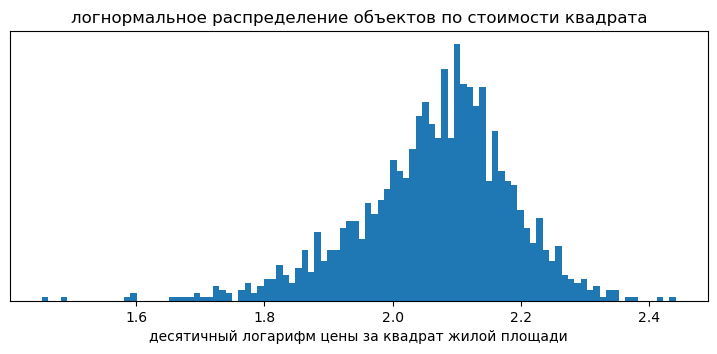

In [16]:
plt.figure(figsize=(9,3.5))
plt.hist(ddf.lg_Y, bins=100)
plt.title('логнормальное распределение объектов по стоимости квадрата')
plt.xlabel('десятичный логарифм цены за квадрат жилой площади')
plt.yticks([])
plt.show()

## выбрасываем ненужные поля

In [17]:
ddf = ddf.drop(columns=['GrLivArea','SalePrice','Y']).copy('deep')
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   GarageCars    1460 non-null   int64  
 2   TotalBsmtSF   1460 non-null   int64  
 3   BsmtFinSF1    1460 non-null   int64  
 4   1stFlrSF      1460 non-null   int64  
 5   BsmtQual      1460 non-null   int64  
 6   2ndFlrSF      1460 non-null   int64  
 7   LotArea       1460 non-null   float64
 8   YearBuilt     1460 non-null   int64  
 9   GarageArea    1460 non-null   float64
 10  YearRemodAdd  1460 non-null   int64  
 11  FullBath      1460 non-null   int64  
 12  Neighborhood  1460 non-null   int64  
 13  TotRmsAbvGrd  1460 non-null   int64  
 14  LotFrontage   1460 non-null   float64
 15  KitchenQual   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OpenPorchSF   1460 non-null   int64  
 18  KitchenQual   1460 non-null 

## так как у нас будет линейная регрессия, необходимо масштабировать все поля к близкому масштабу и разбросу значений

In [18]:
scaler_obj = StandardScaler()
X = scaler_obj.fit_transform(ddf.iloc[:,:-1])
y = ddf.lg_Y.values
X.shape, y.shape

((1460, 26), (1460,))

### проверим, как сработал скейлер

In [19]:
X.mean(axis=0).std(ddof=0)

np.float64(8.799685332349744e-16)

In [20]:
X.std(axis=0, ddof=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Предобработка завершена - переходим к Байесиановой линейной регрессии

**В силу отсутствия компиллятора `g++` и прав на *sudo* пришлось сильно урезать размеры и треды сэмплирования**

## сэмплирование на 26 фичах занимает 25 минут - лучше не перезапускать ячейку ниже!

In [21]:
with pm.Model() as model:
    # Priors for intercept and coefficients
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    # Coefficients for each feature
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected value of target
    mu = alpha + pm.math.dot(X, beta)

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    # Run MCMC sampling
    trace = pm.sample(200, tune=100, cores=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 1510 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## достоверность интерпретации результатов (линейная регрессия как-никак)

In [31]:
view = az.summary(trace, var_names=['alpha', 'beta', 'sigma']).iloc[:,:4]
view['имя поля'] = ['intercept'] + list(ddf.columns)[:-1] + ['error']
view['есть уверенность в знаке зависимости'] = (view.iloc[:,2] * view.iloc[:,3] ) > 0.0
view['есть уверенный тренд'] = view.iloc[:,-1] & (view.iloc[:,0].map(abs) > view.iloc[:,1].map(abs)*4)
print('\n ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ ЛИНЕЙНОЙ РЕГРЕССИИ С ТОЧКИ ЗРЕНИЯ БАЙЕСОВСКОЙ ОЦЕНКИ РАЗБРОСА ПАРАМЕТРОВ:')
view


 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ ЛИНЕЙНОЙ РЕГРЕССИИ С ТОЧКИ ЗРЕНИЯ БАЙЕСОВСКОЙ ОЦЕНКИ РАЗБРОСА ПАРАМЕТРОВ:


,mean,sd,hdi_3%,hdi_97%,имя поля,есть уверенность в знаке зависимости,есть уверенный тренд
alpha,2.066,0.002,2.063,2.069,intercept,True,True
beta[0],0.039,0.003,0.033,0.044,OverallQual,True,True
beta[1],0.013,0.004,0.006,0.020,GarageCars,True,False
beta[2],0.024,0.005,0.014,0.034,TotalBsmtSF,True,True
beta[3],0.006,0.005,-0.003,0.015,BsmtFinSF1,False,False
beta[4],-0.054,0.004,-0.061,-0.046,1stFlrSF,True,True
beta[5],0.012,0.002,0.008,0.016,BsmtQual,True,True
beta[6],-0.056,0.003,-0.063,-0.050,2ndFlrSF,True,True
beta[7],0.015,0.002,0.011,0.018,LotArea,True,True
beta[8],0.033,0.003,0.026,0.039,YearBuilt,True,True


**по недосмостру поле `KitchenQual` попало из variable importance дважды (видимо, два критических значения для ветвления дерева), но Байес разобрался правильно - оба раза показал отсутствие достоверности у интерпретации зависимости!  Гут - работает шайтан-арба!**

## plot traces

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

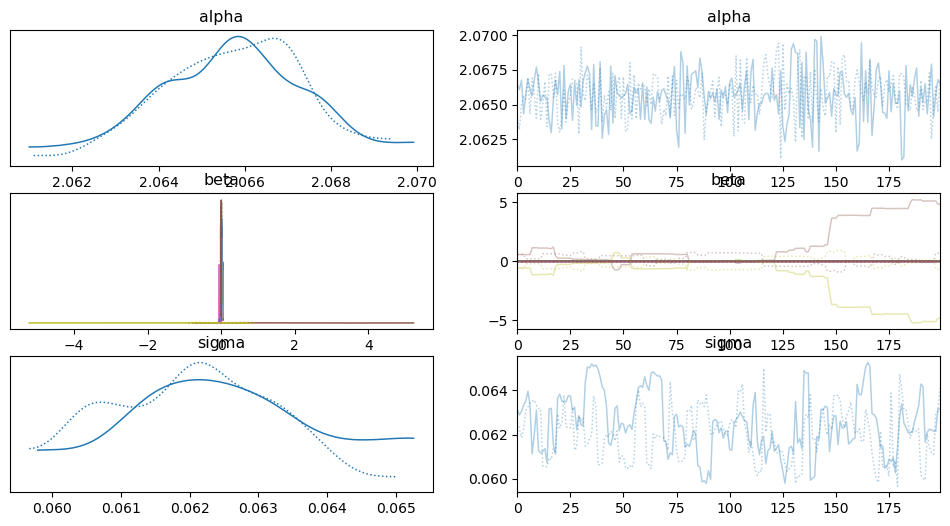

In [32]:
az.plot_trace(trace)

In [35]:
10**0.06, 10**0.065

(1.1481536214968828, 1.1614486138403428)

## выводы:
1) для пары полей мотод MCMC не сошелся
2) но в целом ошибка линейной регресии оказалась порядка $10^{0.060} - 10^{0.065} = 1.15-1.16$, то есть, точность предсказания цены кватрата оказалась 15-16% - очень даже неплохо на таком малом датасете! 

# В заключение посмотрим точность самой линейной модели

## у нас 200 моделей по факту, поэтому усредняем их предсказания

In [73]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['Y_obs'])

preds_mean = ppc.posterior_predictive['Y_obs'].mean(axis=0).mean(axis=0)

Sampling: [Y_obs]


Output()

## и рисуем график

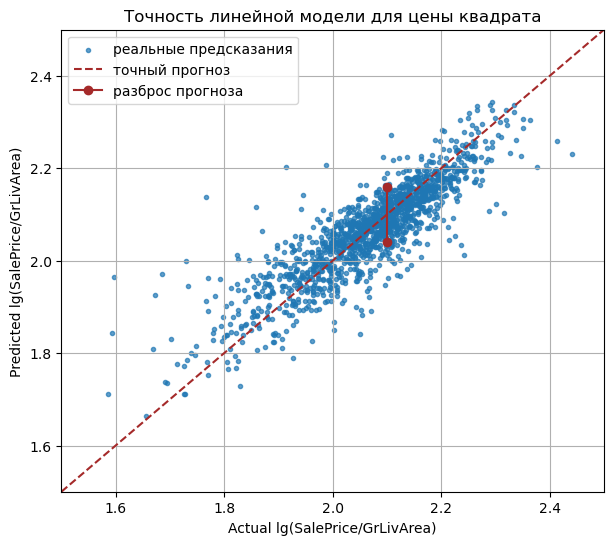

In [74]:
plt.figure(figsize=(7,6))
plt.scatter(y, preds_mean, alpha=0.7, marker='.', label='реальные предсказания')
plt.axline([1.5,1.5], [2.5,2.5], color='brown', ls='--', label='точный прогноз')
plt.plot([2.1,2.1],[2.1-0.06,2.1+0.06], color='brown', marker='o', label='разброс прогноза')
plt.xlabel('Actual lg(SalePrice/GrLivArea)')
plt.ylabel('Predicted lg(SalePrice/GrLivArea)')
plt.title('Точность линейной модели для цены квадрата')
plt.xlim(1.5,2.5)
plt.ylim(1.5,2.5)
plt.grid()
plt.legend(loc='upper left')
plt.show()

**даже при отсутствии возможностей PyTensor получилось довольно точно**